In [2]:
import numpy as np
import skimage.transform as skt
import matplotlib.pyplot as plt
import matplotlib.image
import scipy.io as sio
import os

0
1
2
3
4
5


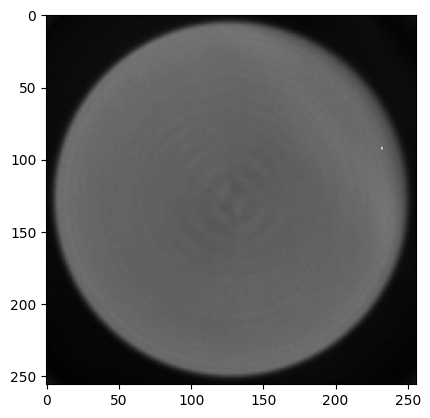

In [6]:
reshape_shape = [256, 256]
Dir = '/media/alingold/MenonLab/20231012_tile'
CCMcrop = [225, 480, 220, 475]
#CCMcrop = [237, 492, 223, 478]
REFcrop = [430, 820, 425, 815]

ref_imgs = []
ref_imgs1 = []
ccm_imgs = []
ccm_imgs1 = []
Len = 6
yLen = 7
zLen = 10
for X in range(Len):
    print(X)
    for Y in range(yLen):
        for Z in range(zLen):
            # print(Y)
            #Mat = "x{}_y{}_z0.mat".format(X, Y)
            Mat = "x{}_y{}_z{}_t0.mat".format(X, Y, Z)
            Path = os.path.join(Dir, Mat)
            Struct = sio.loadmat(Path, verify_compressed_data_integrity=False)
            Struct.keys()
            
            ref_img = Struct["objRef"]
            ccm_img = Struct["objCCM"]
            
            if ref_img.size < 1:
                Exp = "x{}_y{}.mat Ref is empty".format(X, Y)
                print(Exp)
                continue
            if np.max(ref_img) > 254:
                Exp = "x{}_y{}.mat Ref is overexposed".format(X,Y)
                print(Exp)
                print(np.max(ref_img))
                continue
            # if np.max(ref_img) == 1:
            #     Exp = "x{}_y{}.mat Ref is has a max of 1".format(X, Y)
            #     print(Exp)
            #     continue
            if np.max(ccm_img) > 65530:
                Exp = "x{}_y{}_z0.mat CCM is overexposed".format(X,Y)
                print(Exp)
                print(np.max(ccm_img))
                continue
            if ccm_img.size < 1:
                Exp = "x{}_y{}.mat CCM is empty".format(X, Y)
                print(Exp)
                continue
    
    
            ref_img = ref_img[REFcrop[2]:REFcrop[3], REFcrop[0]:REFcrop[1]]
            ref_img = ref_img - np.min( ref_img)
            ref_img = np.single(ref_img / (np.max( ref_img)+0.0001))
            ref_img = skt.resize( ref_img, reshape_shape)
            #plt.figure()
            plt.imshow(ref_img, cmap='gray')
            ref_imgs.append( ref_img)
            
            ccm_img = ccm_img[CCMcrop[2]:CCMcrop[3], CCMcrop[0]:CCMcrop[1]]
            ccm_img = ccm_img - np.min( ccm_img)
            ccm_img = np.single(ccm_img / np.max( ccm_img))
            ccm_img = skt.resize( ccm_img, reshape_shape)
            #plt.figure()
            plt.imshow(ccm_img, cmap='gray')
            ccm_imgs.append( ccm_img)


In [7]:
#ref_imgs = np.array( ref_imgs_reshaped)
#ccm_imgs = np.array( ccm_imgs_reshaped)
np.save(Dir + '_ccm.npy', ccm_imgs)
np.save(Dir + '_ref.npy', ref_imgs)
print(np.shape(ref_imgs))
print(np.max(ref_imgs))
print(np.shape(ccm_imgs))
print(np.max(ccm_imgs))

(420, 256, 256)
0.99999905
(420, 256, 256)
0.7900955


In [9]:
# process beads into 3D npyimport multiprocessing as mp
import multiprocessing as mp
import os
import numpy as np
import scipy.io as sio
import skimage.transform as skt
from tqdm import tqdm

ref_imgs = mp.Manager().list()
ccm_imgs = mp.Manager().list()

Len = 25
yLen = 25

def process_imgs(X):
    for Y in range(yLen):
        Mat = "x{}_y{}_z0.mat".format(X, Y)
        Path = os.path.join(Dir, Mat)
        try:
            Struct = sio.loadmat(Path, verify_compressed_data_integrity=False)
            Struct.keys()
        except (ValueError, TypeError, NotImplementedError) as e:
            print(f"Error loading {Path}: {str(e)}")
            continue

        ref_img = Struct["objRef"]
        ccm_img = Struct["objCCM"]

        if ref_img.size < 1 or np.max(ref_img) > 254 or np.max(ref_img) == 1 or ccm_img.size < 1 or np.max(ccm_img) > 65530:
            print('a condition failed')
            break

        ref_img = ref_img[REFcrop[2]:REFcrop[3], REFcrop[0]:REFcrop[1]]
        ref_img = ref_img - np.min(ref_img)
        ref_img = np.single(ref_img / (np.max(ref_img)+0.0001))
        ref_img = skt.resize(ref_img, reshape_shape)
        ref_imgs.append(ref_img)

        ccm_img = ccm_img[CCMcrop[2]:CCMcrop[3], CCMcrop[0]:CCMcrop[1]]
        ccm_img = ccm_img - np.min(ccm_img)
        ccm_img = np.single(ccm_img / np.max(ccm_img))
        ccm_img = skt.resize(ccm_img, reshape_shape)
        ccm_imgs.append(ccm_img)

if __name__ == '__main__':
    with mp.Pool(mp.cpu_count()) as pool:
        list(tqdm(pool.imap(process_imgs, range(Len)), total=Len))


  0%|                                                                                                                                                                                       | 0/25 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/media/alingold/MenonLab/20230803_50um_bead_calTest/x0_y2_z0.mat'

In [6]:
# reshape for 4D calibration matrix

import numpy as np

def reshape_grid(arr):
    if arr.shape != (625, 128, 128):
        raise ValueError("Input array must have shape (625, 256, 256)")

    x_len = 25
    y_len = 25

    # Reshape the array into the desired grid shape
    #reshaped_array = arr.reshape((x_len, y_len, 256, 256))
    reshaped_array = np.zeros([25, 25, 128, 128])

    for X in range(x_len):
        for Y in range(y_len):
            reshaped_array[X, Y] = arr[(X + 25*Y), :, :]
    return reshaped_array

ref_imgs = np.array( ref_imgs)
ccm_imgs = np.array( ccm_imgs)
ref_imgs_reshaped = reshape_grid(ref_imgs)
ccm_imgs_reshaped = reshape_grid(ccm_imgs)


In [3]:
# process beads into 4D npyimport multiprocessing as mp
import multiprocessing as mp
import os
import numpy as np
import scipy.io as sio
import skimage.transform as skt
from tqdm import tqdm

xLen = 25
yLen = 25
ref_imgs = np.zeros([xLen, yLen, reshape_shape[0], reshape_shape[1]])
ccm_imgs = np.zeros([xLen, yLen, reshape_shape[0], reshape_shape[1]])

for X in range(xLen):
    for Y in range(yLen):
        Mat = "x{}_y{}_z0.mat".format(X, Y)
        Path = os.path.join(Dir, Mat)
        try:
            Struct = sio.loadmat(Path, verify_compressed_data_integrity=False)
            Struct.keys()
        except (ValueError, TypeError, NotImplementedError) as e:
            print(f"Error loading {Path}: {str(e)}")
            continue

        ref_img = Struct["objRef"]
        ccm_img = Struct["objCCM"]

        if ref_img.size < 1 or np.max(ref_img) > 254 or np.max(ref_img) == 1 or ccm_img.size < 1 or np.max(ccm_img) > 65530:
            print('a condition failed')
            break

        ref_img = ref_img[REFcrop[2]:REFcrop[3], REFcrop[0]:REFcrop[1]]
        ref_img = ref_img - np.min(ref_img)
        ref_img = np.single(ref_img / (np.max(ref_img)+0.0001))
        ref_img = skt.resize(ref_img, reshape_shape)
        ref_imgs[X, Y] = ref_img

        ccm_img = ccm_img[CCMcrop[2]:CCMcrop[3], CCMcrop[0]:CCMcrop[1]]
        ccm_img = ccm_img - np.min(ccm_img)
        ccm_img = np.single(ccm_img / np.max(ccm_img))
        ccm_img = skt.resize(ccm_img, reshape_shape)
        ccm_imgs[X, Y] = ccm_img

ref_imgs = np.array( ref_imgs)
ccm_imgs = np.array( ccm_imgs)
np.save(Dir + '_ccm.npy', ccm_imgs)
np.save(Dir + '_ref.npy', ref_imgs)
print(np.shape(ref_imgs))
print(np.max(ref_imgs))
print(np.shape(ccm_imgs))
print(np.max(ccm_imgs))

(25, 25, 256, 256)
0.9999995827674866
(25, 25, 256, 256)
0.9997672438621521


In [ ]:
# Solution 1: Deal with super large datasets

chunk_size = 100 # Choose a reasonable chunk size that works well with your hardware.
n_chunks = len(ref_imgs) // chunk_size

for i in range(n_chunks+1):
    start = i * chunk_size
    end = start + chunk_size
    ref_chunk = np.array(ref_imgs[start:end])
    ccm_chunk = np.array(ccm_imgs[start:end])
    np.save(Dir + f'_512_ref_chunk_{i}.npy', ref_chunk)
    np.save(Dir + f'_512_ccm_chunk_{i}.npy', ccm_chunk)

# Solution 2: Memory Mapping

shape = (len(ref_imgs), 512, 512) # Assuming the images are 512x512.

# Creating memory-mapped arrays for reference and ccm images.
ref_mmapped = np.lib.format.open_memmap(Dir + '_512_ref.npy', mode='w+', dtype=np.float32, shape=shape)
ccm_mmapped = np.lib.format.open_memmap(Dir + '_512_ccm.npy', mode='w+', dtype=np.float32, shape=shape)

# Filling the memory-mapped arrays.
for i in range(len(ref_imgs)):
    ref_mmapped[i] = np.array(ref_imgs[i])
    ccm_mmapped[i] = np.array(ccm_imgs[i])


In [10]:
import numpy as np

# Load the two NumPy arrays
ref_imgs1 = np.load('20230605_200um50na_longexp_1_mechcrop1_ccm.npy')
ref_imgs2 = np.load('20230605_200um50na_longexp_2_mechcrop2_ccm.npy')

# Append the two arrays
combined_imgs = np.append(ref_imgs1, ref_imgs2, axis=0)

# Save the combined array
np.save('20230605_200um50na_longexp_combined_mechcrop_ccm.npy', combined_imgs)
